## Access, obtain and filter ATL06 Data

#### This notebook aims to query, obtain, subset and filter ATL06 data in region of interest (hereinafter ROI), basic workflow is:
<ol>
<li>Inquire available ATL06 data based on bounding box of ROI in this project</li>
<li>Two differnt ways of obtaining ATL06 data:</li>
<ol>
<li>Read data directly from OpenAltimetry API without downloading, suitable for quick check and simple manipulation of elevation in ROI</li>
<li>Download data from NSIDC, subset variables and data filtering, suitable for complex data analysis</li>
</ol>
</ol>

##### References:
* Notebooks by Fernando Paolo: https://github.com/ICESAT-2HackWeek/intro-hdf5 
* Notebooks by Jessica Scheick and Amy Steiker: https://github.com/ICESAT-2HackWeek/data-access 

In [13]:
# Import packages
from pathlib import Path
from icepyx import icesat2data as ipd
import h5py
import numpy as np
import dask.dataframe as dd
import warnings
warnings.filterwarnings("ignore")

from simlib import atl06lib # subset and filter ATL06 data
from simlib.icesatapi import file_meta, OA_request  # request data from OpenAltimetry API

In [14]:
# Download folder 
data_home = Path('/home/jovyan/data/ATL06_RAW') #/home/jovyan/shared/data-tian/ATL06_RAW

# Output folder
outdir = Path.home()/'data/ATL06_Processed'

# Create folder if it doesn't exist
data_home.mkdir(exist_ok=True)
outdir.mkdir(exist_ok=True)

## 1. Query ATL06 data in ROI
#### Create an ICESat-2 data object with the desired search parameters
Required parameters for data query: 
* short_name
* date_range
* spatial_extent: derived from DEM

Spatial extents(bbox): The spatial extent is a required input for data access. Much like how your spatial extent in OpenAltimetry showed which tracks were available, this input provides an easy way for the NSIDC API to search through the ICESat-2 metadata and determine which granules might have some coverage there (without having to open all the individual granules, which would take a lot of computing resources). Then, this same spatial region will be used a second time to actually extract the data for the region you're interested in (which is why you might get a message during ordering saying a given granule didn't have any data in your region of interest).

epsg: DEM projection, will be used in projection convertion when reducing ATL06 files

In [15]:
# query datasets
short_name = 'ATL06'
date_range = ['2018-10-14','2020-04-04']

#Baker DEM
bbox = [-121.87893182746436, 48.70258466806347, -121.79542720391288, 48.7704252035505] #[lonmin,latmin,lonmax,latmax]
#[-76.5,-79.5,-76,-79] Antarctic 
epsg = 32610 # projection

region = ipd.Icesat2Data(short_name, bbox, date_range)

#### Set Earthdata login account

In [16]:
# Earthdata Login user name and associated email
earthdata_uid = 'icetianli'
email = 'tian.li@bristol.ac.uk'

#### Check parameters and visualization

product:     ATL06
dates:       ['2018-10-14', '2020-04-04']
start time:  00:00:00
end time:    23:59:59
version:     003
extent:      ['bounding box', [-121.87893182746436, 48.70258466806347, -121.79542720391288, 48.7704252035505]]

DATA:
('Number of available granules', 28)
('Average size of granules (MB)', 16.003927980146425)
('Total size of all granules (MB)', 448.1099834441)


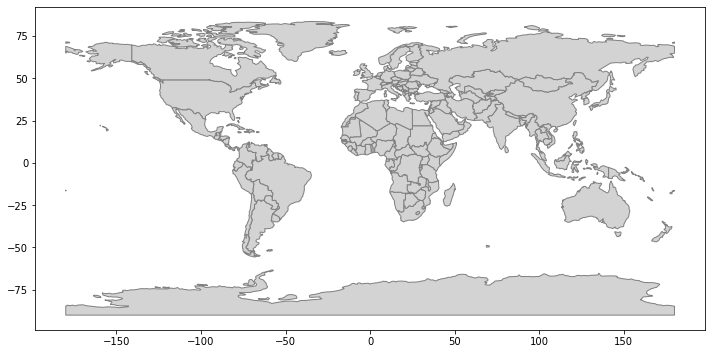

In [17]:
print('product:    ', region.dataset)
print('dates:      ', region.dates)
print('start time: ', region.start_time)
print('end time:   ', region.end_time)
print('version:    ', region.dataset_version)
print('extent:     ', region.spatial_extent)

#search for available granules and provide basic summary info about them
print('\nDATA:')
print('\n'.join([str(item) for item in region.avail_granules().items()]))

# visualize data extents
region.visualize_spatial_extent()

#### Obtain ATL06 granule list

In [18]:
filelist = region.avail_granules(ids=True)
filelist

['ATL06_20181019231110_03260102_003_01.h5',
 'ATL06_20181030110205_04860106_003_01.h5',
 'ATL06_20181117214724_07680102_003_01.h5',
 'ATL06_20181128093802_09280106_003_01.h5',
 'ATL06_20181231080552_00440206_003_01.h5',
 'ATL06_20190118185056_03260202_003_01.h5',
 'ATL06_20190129064202_04860206_003_01.h5',
 'ATL06_20190216172712_07680202_003_01.h5',
 'ATL06_20190227051804_09280206_003_01.h5',
 'ATL06_20190401034544_00440306_003_01.h5',
 'ATL06_20190419143053_03260302_003_01.h5',
 'ATL06_20190430022142_04860306_003_01.h5',
 'ATL06_20190518130651_07680302_003_01.h5',
 'ATL06_20190529005739_09280306_003_01.h5',
 'ATL06_20190729220121_04860406_003_01.h5',
 'ATL06_20190817084636_07680402_003_01.h5',
 'ATL06_20190827203728_09280406_003_01.h5',
 'ATL06_20190929190514_00440506_003_01.h5',
 'ATL06_20191018055026_03260502_003_01.h5',
 'ATL06_20191028174117_04860506_003_01.h5',
 'ATL06_20191116042631_07680502_003_01.h5',
 'ATL06_20191126161720_09280506_003_01.h5',
 'ATL06_20191229144501_00440606_

## 2 Obtain ATL06 data in ROI
### 2.1 Read ATL06 data directly from OpenAltimetry API
**This method reads unfiltered data directly from OepnAltimtery into memory without actually downloading onto local disk. If you just want a quick look or simple manipulation of the elevation data in ROI**, this method can be the option. 
The returned parameters are:
* lat: latitude of segment
* lon: longitude of segment
* h: elevation
* beam: beam number
* cycle: ATL06 cycle number
* time: acquisiton date of data granule

**If you want to obtain a more complete list of ATL06 variables and perform complex data analysis, then refer to section 2.2, it offers a higher flexibility of accessing different variables and support data filtering.**

CPU times: user 4.81 s, sys: 263 ms, total: 5.08 s
Wall time: 5.75 s


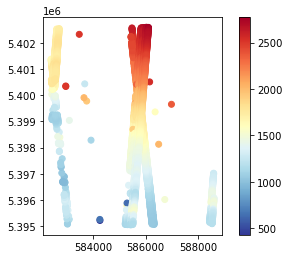

In [19]:
%%time
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt 
from pyproj import CRS
from itertools import compress
import concurrent.futures

para_lists = file_meta(filelist,bbox)

### Parallel processing ###
pool = concurrent.futures.ThreadPoolExecutor(max_workers=20)
parallel_data = {pool.submit(OA_request,paralist): paralist for paralist in para_lists}

results=[]
for future in concurrent.futures.as_completed(parallel_data):
    r = future.result()
    results.append(r)
    
ATL06_DATA = pd.concat(results) 
# convert into geodataframe
geometry = [Point(xy) for xy in zip(ATL06_DATA['lon'], ATL06_DATA['lat'])]        
gdf_OA = gpd.GeoDataFrame(ATL06_DATA, geometry=geometry, crs=CRS('EPSG:4326'))
gdf_OA = gdf_OA.to_crs({'init':'epsg:'+str(epsg)})

# plot elevation
fig,ax = plt.subplots()
gdf_OA.plot(column='h', ax=ax, legend=True, cmap='RdYlBu_r');

### 2.2 Download data from NSIDC, reduce and filter downloaded ATL06 data 

#### Download Data

In [20]:
# Only download if data folder is empty
if not list(data_home.glob('*.h5')):
    region.earthdata_login(earthdata_uid, email)
    region.order_granules(email=False)
    region.download_granules(data_home)

In [21]:
#Check downloaded data
files = list(data_home.glob('*.h5'))

for f in files[:10]: print(f)
print('Total number of files:', len(files))

#check the ICESat-2 file structure (!)
#!h5ls -r {files[0]} 

/home/jovyan/data/ATL06_RAW/processed_ATL06_20190430022142_04860306_003_01.h5
/home/jovyan/data/ATL06_RAW/processed_ATL06_20190129064202_04860206_003_01.h5
/home/jovyan/data/ATL06_RAW/processed_ATL06_20181019231110_03260102_003_01.h5
/home/jovyan/data/ATL06_RAW/processed_ATL06_20190419143053_03260302_003_01.h5
/home/jovyan/data/ATL06_RAW/processed_ATL06_20190729220121_04860406_003_01.h5
/home/jovyan/data/ATL06_RAW/processed_ATL06_20190118185056_03260202_003_01.h5
Total number of files: 6


#### Reduce and filter ATL06 Data

In [22]:
!python system-status.py

I am currently running on Linux version 4.14.177.  
This system is named jupyter-icetianli 
It has 8 CPU cores.  
It has 30 Gigabytes of RAM.  
Current disk_percent is 4.9 percent.  
Current CPU utilization is 16.7 percent.  
Current memory utilization is 39.6 percent. 
it's running since Wednesday 17. June 2020. 



In [23]:
# Parallelization

njobs = 2 

if njobs == 1:
    print('running in serial ...')
    [atl06lib.read_atl06(f, epsg, outdir, bbox) for f in files]

else:
    print('running in parallel (%d jobs) ...' % njobs)
    from joblib import Parallel, delayed
    Parallel(n_jobs=njobs, verbose=5)(delayed(atl06lib.read_atl06)(f, epsg, outdir, bbox) for f in files)

running in parallel (2 jobs) ...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    9.9s finished


In [24]:
# check reduced ATL06 files
outfiles = list(outdir.glob('*.h5'))

for f in outfiles[:]: print(f)
print('Total number of files:', len(outfiles))

# check variable list
print('Variables:')
!h5ls -r {outfiles[0]}

/home/jovyan/data/ATL06_Processed/processed_ATL06_20190430022142_04860306_003_01_gt2r.h5
/home/jovyan/data/ATL06_Processed/processed_ATL06_20190129064202_04860206_003_01_gt3r.h5
/home/jovyan/data/ATL06_Processed/processed_ATL06_20190729220121_04860406_003_01_gt3l.h5
/home/jovyan/data/ATL06_Processed/processed_ATL06_20181019231110_03260102_003_01_gt1l.h5
/home/jovyan/data/ATL06_Processed/processed_ATL06_20190129064202_04860206_003_01_gt3l.h5
/home/jovyan/data/ATL06_Processed/processed_ATL06_20190729220121_04860406_003_01_gt1l.h5
/home/jovyan/data/ATL06_Processed/processed_ATL06_20181019231110_03260102_003_01_gt1r.h5
/home/jovyan/data/ATL06_Processed/processed_ATL06_20190729220121_04860406_003_01_gt3r.h5
/home/jovyan/data/ATL06_Processed/processed_ATL06_20190430022142_04860306_003_01_gt2l.h5
/home/jovyan/data/ATL06_Processed/processed_ATL06_20190430022142_04860306_003_01_gt3r.h5
/home/jovyan/data/ATL06_Processed/processed_ATL06_20190729220121_04860406_003_01_gt2r.h5
/home/jovyan/data/ATL

#### Plot data

In [27]:
# Get list of files to plot
files = list(outdir.glob('*.h5'))

dfs = []
for f in files[:]:
    f_data, vnames = atl06lib.read_h5(f)
    dd_data = dd.from_array(f_data, columns=vnames)
    dfs.append(dd_data)

# List with one dataframe per file
#dfs = [dd.from_array(atl06lib.read_h5(f), columns=vnames) for f in files] #

# Single parallel dataframe (larger than memory)
df = dd.concat(dfs)

print('Number of files:', len(files))
print('Number of points:', len(df))
#print(df.head())

# dask dataframe convert to pandas dataframe
df_nsidc = df.compute()

print (df_nsidc.head())

Number of files: 17
Number of points: 894
        dac  dh_fit_dx   f_sn         h_li      h_rb  is_asc        lat  \
0 -0.078387  -0.263047  127.0  2641.562988  0.981449     0.0  48.769324   
1 -0.078386  -0.349660  127.0  2635.364014  0.951949     0.0  48.769144   
2 -0.078381  -0.148199  127.0  2603.774902  0.729345     0.0  48.768427   
3 -0.078380  -0.075832  127.0  2601.487793  0.717039     0.0  48.768247   
4 -0.078379  -0.081239  127.0  2599.798340  0.700932     0.0  48.768068   

          lon  q_flag  s_fg  ...  snr          t_dt         t_gps  \
0 -121.832047     0.0   0.0  ...  0.0  4.182627e+07  1.240626e+09   
1 -121.832073     0.0   0.0  ...  0.0  4.182627e+07  1.240626e+09   
2 -121.832173     0.0   0.0  ...  0.0  4.182627e+07  1.240626e+09   
3 -121.832198     0.0   0.0  ...  0.0  4.182627e+07  1.240626e+09   
4 -121.832224     0.0   0.0  ...  0.0  4.182627e+07  1.240626e+09   

        t_year  tide_earth  tide_load    tide_ocean  tide_pole              x  \
0  2019.326

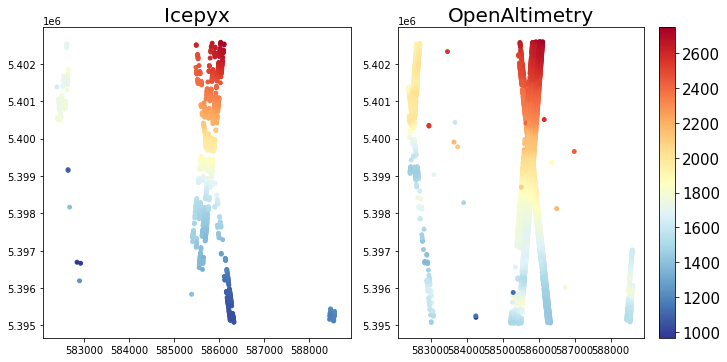

In [28]:
# plot elevation
fig=plt.figure(figsize=(10, 5))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122, sharex=ax1, sharey=ax1)

cm = plt.cm.get_cmap('RdYlBu_r')
cs=ax1.scatter(df_nsidc['x'], df_nsidc['y'], c=df_nsidc['h_li'], vmin=df_nsidc['h_li'].min(), vmax=df_nsidc['h_li'].max(), cmap=cm, s=15, label='Icepyx')
ax2.scatter(gdf_OA['geometry'].x, gdf_OA['geometry'].y, c = gdf_OA['h'], vmin=gdf_OA['h'].min(), vmax=gdf_OA['h'].max(), cmap=cm, s=15, label='OpenAltimetry')

plt.tight_layout()
ax1.set_title('Icepyx', fontsize=20)
ax2.set_title('OpenAltimetry', fontsize=20)
colorbar = fig.colorbar(cs, ax=ax2)
colorbar.ax.tick_params(labelsize=15)
plt.show()